## Zillow Housing Data Time Series Projections

## Setup

In [55]:
import pandas as pd
import matplotlib as mpl
import numpy as np
from sklearn import metrics

%load_ext autoreload
%autoreload 2

import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
sys.path.insert(0, '../code')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
mpl.rc('font', **font)
mpl.rc('figure', max_open_warning = 0)
             
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',400)

from code.functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA

## Load Data

Load 1-bedroom and 2-bedroom home value data, sourced from Zillow Research.

In [56]:
df_1_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
df_2_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

Extract San Franciso data.

In [57]:
df_1_bd = df_1_bd[df_1_bd.CountyName == 'San Francisco County']
df_2_bd = df_2_bd[df_2_bd.CountyName == 'San Francisco County']

Check the shape of the datasets.

In [58]:
print("Shape of 1 Bedroom dataset for San Franciso is ", df_1_bd.shape)
print("Shape of 2 Bedroom dataset for San Franciso is ", df_2_bd.shape)

Shape of 1 Bedroom dataset for San Franciso is  (25, 311)
Shape of 2 Bedroom dataset for San Franciso is  (25, 311)


In [59]:
df_1_bd.head()

RegionID  SizeRank  RegionName RegionType StateName State           City  \
12      97564        13       94109        Zip        CA    CA  San Francisco   
89      97565        94       94110        Zip        CA    CA  San Francisco   
368     97576       391       94122        Zip        CA    CA  San Francisco   
557     97567       592       94112        Zip        CA    CA  San Francisco   
817     97569       864       94115        Zip        CA    CA  San Francisco   

                             Metro            CountyName  1996-01-31  \
12   San Francisco-Oakland-Hayward  San Francisco County    260256.0   
89   San Francisco-Oakland-Hayward  San Francisco County    217471.0   
368  San Francisco-Oakland-Hayward  San Francisco County    288096.0   
557  San Francisco-Oakland-Hayward  San Francisco County    204717.0   
817  San Francisco-Oakland-Hayward  San Francisco County    218208.0   

     1996-02-29  1996-03-31  1996-04-30  1996-05-31  1996-06-30  1996-07-31  \
12     259464.0    259741.0    260283.0    261841.0    263092.0    264205.0   
89     216242.0    215151.0    213865.0    212348.0    210852.0    209758.0   
368    286892.0    286226.0    284783.0    282620.0    280098.0    277593.0   
557    204247.0    204207.0    203668.0    202737.0    202199.0    201383.0   
817    217938.0    217934.0    218239.0    218803.0    219201.0    219127.0   

     1996-08-31  1996-09-30  1996-10-31  1996-11-30  1996-12-31  1997-01-31  \
12     265654.0    266982.0    268514.0    269250.0    270052.0    270706.0   
89     209934.0    211016.0    211975.0    212251.0    212875.0    214119.0   
368    277502.0    278304.0    279194.0    279452.0    280182.0    282242.0   
557    201399.0    200705.0    200733.0    200642.0    200988.0    201595.0   
817    219374.0    220073.0    220861.0    221659.0    223060.0    224494.0   

     1997-02-28  1997-03-31  1997-04-30  1997-05-31  1997-06-30  1997-07-31  \
12     272850.0    275068.0    276733.0    277569.0    279036.0    281145.0   
89     217468.0    221214.0    224125.0    227544.0    232142.0    236628.0   
368    284562.0    286359.0    287629.0    290653.0    294645.0    299464.0   
557    202674.0    203756.0    205096.0    207004.0    208502.0    210740.0   
817    226296.0    227807.0    229380.0    231216.0    233310.0    236314.0   

     1997-08-31  1997-09-30  1997-10-31  1997-11-30  1997-12-31  1998-01-31  \
12     282877.0    285615.0    288679.0    293228.0    297098.0    301854.0   
89     240410.0    242876.0    245904.0    249341.0    253778.0    258389.0   
368    301656.0    303676.0    306446.0    311119.0    315687.0    319163.0   
557    212322.0    215041.0    217517.0    221136.0    224333.0    227637.0   
817    239125.0    241915.0    244807.0    248080.0    250918.0    254609.0   

     1998-02-28  1998-03-31  1998-04-30  1998-05-31  1998-06-30  1998-07-31  \
12     306116.0    309977.0    314039.0    317579.0    321445.0    325343.0   
89     260861.0    263608.0    266219.0    270811.0    274514.0    279522.0   
368    323153.0    327452.0    331987.0    336125.0    341211.0    346224.0   
557    230085.0    232485.0    234688.0    237477.0    240331.0    243117.0   
817    258040.0    261743.0    264491.0    266781.0    269827.0    273594.0   

     1998-08-31  1998-09-30  1998-10-31  1998-11-30  1998-12-31  1999-01-31  \
12     329714.0    333798.0    337336.0    340579.0    344750.0    348166.0   
89     283694.0    289501.0    295742.0    305065.0    311876.0    317809.0   
368    351131.0    354977.0    358463.0    360786.0    363130.0    364870.0   
557    245790.0    248981.0    251293.0    252405.0    253787.0    255124.0   
817    277164.0    280340.0    283334.0    286948.0    289498.0    291138.0   

     1999-02-28  1999-03-31  1999-04-30  1999-05-31  1999-06-30  1999-07-31  \
12     351846.0    355766.0    360417.0    365214.0    369852.0    374002.0   
89     322899.0    327732.0    334109.0    338630.0    344254.0    347833.0  

In [60]:
df_2_bd.head()

RegionID  SizeRank  RegionName RegionType StateName State           City  \
13      97564        13       94109        Zip        CA    CA  San Francisco   
93      97565        94       94110        Zip        CA    CA  San Francisco   
388     97576       391       94122        Zip        CA    CA  San Francisco   
587     97567       592       94112        Zip        CA    CA  San Francisco   
859     97569       864       94115        Zip        CA    CA  San Francisco   

                             Metro            CountyName  1996-01-31  \
13   San Francisco-Oakland-Hayward  San Francisco County    395027.0   
93   San Francisco-Oakland-Hayward  San Francisco County    244323.0   
388  San Francisco-Oakland-Hayward  San Francisco County    270792.0   
587  San Francisco-Oakland-Hayward  San Francisco County    226713.0   
859  San Francisco-Oakland-Hayward  San Francisco County    304296.0   

     1996-02-29  1996-03-31  1996-04-30  1996-05-31  1996-06-30  1996-07-31  \
13     392274.0    391226.0    388511.0    386522.0    384656.0    383879.0   
93     243832.0    243384.0    243268.0    243232.0    242939.0    242575.0   
388    269969.0    269742.0    269136.0    268485.0    267881.0    266968.0   
587    226315.0    226098.0    225489.0    224636.0    224077.0    223523.0   
859    304033.0    304380.0    305044.0    306225.0    307977.0    308804.0   

     1996-08-31  1996-09-30  1996-10-31  1996-11-30  1996-12-31  1997-01-31  \
13     384905.0    387166.0    389492.0    392773.0    396437.0    401525.0   
93     243329.0    244959.0    246342.0    247368.0    249060.0    251712.0   
388    267036.0    267141.0    268384.0    269688.0    271840.0    274389.0   
587    223561.0    223367.0    223652.0    224073.0    224713.0    225746.0   
859    309762.0    310192.0    311808.0    313341.0    314915.0    316546.0   

     1997-02-28  1997-03-31  1997-04-30  1997-05-31  1997-06-30  1997-07-31  \
13     407460.0    412096.0    416288.0    421565.0    427768.0    433598.0   
93     255269.0    259144.0    262668.0    266229.0    270207.0    274252.0   
388    277414.0    279955.0    282258.0    285302.0    289003.0    293801.0   
587    227120.0    228754.0    230598.0    232986.0    235327.0    238007.0   
859    318570.0    320535.0    322052.0    323586.0    324619.0    327871.0   

     1997-08-31  1997-09-30  1997-10-31  1997-11-30  1997-12-31  1998-01-31  \
13     436851.0    439971.0    443803.0    447826.0    451208.0    454305.0   
93     277495.0    280310.0    284069.0    287788.0    291333.0    293547.0   
388    297975.0    302186.0    305443.0    308965.0    312298.0    315422.0   
587    240485.0    243619.0    246683.0    250120.0    253683.0    256524.0   
859    331949.0    337037.0    340223.0    343288.0    346581.0    351189.0   

     1998-02-28  1998-03-31  1998-04-30  1998-05-31  1998-06-30  1998-07-31  \
13     457637.0    462311.0    468395.0    473483.0    479751.0    485969.0   
93     294973.0    296359.0    297547.0    300432.0    304143.0    309323.0   
388    318716.0    322092.0    326001.0    329879.0    333780.0    337393.0   
587    258870.0    260878.0    263406.0    266500.0    269655.0    272999.0   
859    356282.0    361656.0    367136.0    372104.0    377550.0    382242.0   

     1998-08-31  1998-09-30  1998-10-31  1998-11-30  1998-12-31  1999-01-31  \
13     494312.0    500605.0    507084.0    511696.0    518599.0    524303.0   
93     313693.0    317845.0    321438.0    327582.0    332838.0    338939.0   
388    340776.0    344843.0    348242.0    351389.0    353126.0    355300.0   
587    276180.0    279704.0    282804.0    285270.0    287598.0    290900.0   
859    385604.0    388609.0    392988.0    399222.0    405490.0    409377.0   

     1999-02-28  1999-03-31  1999-04-30  1999-05-31  1999-06-30  1999-07-31  \
13     532287.0    540316.0    547897.0    554617.0    558807.0    563294.0   
93     344943.0    350841.0    356160.0    359467.0    364101.0    368065.0  

Check that both datasets have the same columns names for all 311 columns.

In [61]:
(df_1_bd.columns == df_2_bd.columns).sum()

311

## Data Exploration

Check for missing values. A few zip codes have older dates missing, we will handle those later.

In [142]:
df_1_missing = df_1_bd.isna().sum()
df_1_missing[(df_1_missing!=0)]

1996-01-31    2
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
             ..
2007-08-31    1
2007-09-30    1
2007-10-31    1
2007-11-30    1
2007-12-31    1
Length: 144, dtype: int64

In [143]:
df_1_missing[(df_1_missing!=0)].max()

2

In [149]:
df_2_missing = df_2_bd.isna().sum()
df_2_missing[(df_2_missing!=0)]

1996-01-31    3
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
             ..
2006-02-28    1
2006-03-31    1
2006-04-30    1
2006-05-31    1
2006-06-30    1
Length: 126, dtype: int64

In [150]:
df_2_missing[(df_2_missing!=0)].max()

3

The way the data is displayed currently makes it quite hard to interpret. There must be a better way...

In [64]:
df_1_bd.describe()

RegionID      SizeRank    RegionName     1996-01-31     1996-02-29  \
count     25.000000     25.000000     25.000000      23.000000      23.000000   
mean   97572.560000   3844.040000  94118.240000  252714.043478  252364.478261   
std       12.193167   4929.422874     12.810412   53351.352222   53516.025256   
min    97557.000000     13.000000  94102.000000  149001.000000  147622.000000   
25%    97564.000000   1041.000000  94109.000000  222230.500000  222449.500000   
50%    97570.000000   2073.000000  94116.000000  257728.000000  256479.000000   
75%    97578.000000   4170.000000  94124.000000  283896.000000  283491.000000   
max    97610.000000  22468.000000  94158.000000  390276.000000  390252.000000   

          1996-03-31     1996-04-30     1996-05-31     1996-06-30  \
count      23.000000      23.000000      23.000000      23.000000   
mean   251782.391304  251039.652174  250138.260870  249686.086957   
std     53512.015019   53585.449265   53436.040036   53336.684724   
min    146381.000000  143989.000000  142947.000000  142289.000000   
25%    222196.500000  222164.500000  221673.000000  220716.500000   
50%    256110.000000  255142.000000  254819.000000  253757.000000   
75%    284263.000000  284898.500000  284539.500000  283080.000000   
max    389033.000000  387222.000000  384796.000000  383291.000000   

          1996-07-31     1996-08-31     1996-09-30     1996-10-31  \
count      23.000000      23.000000      23.000000      23.000000   
mean   249109.434783  249207.956522  249520.565217  250026.652174   
std     53005.321011   53014.576423   52991.701031   53136.085080   
min    142284.000000  141582.000000  141742.000000  141881.000000   
25%    219639.500000  218987.500000  219244.000000  219977.500000   
50%    253065.000000  254159.000000  255002.000000  256056.000000   
75%    281152.000000  278713.500000  276074.000000  274633.000000   
max    380740.000000  379473.000000  379187.000000  380383.000000   

          1996-11-30     1996-12-31     1997-01-31     1997-02-28  \
count      23.000000      23.000000      23.000000      23.000000   
mean   250409.260870  250976.956522  252050.652174  253312.000000   
std     53145.891099   53376.076644   53815.203635   53956.279862   
min    142518.000000  142203.000000  142173.000000  142780.000000   
25%    221021.500000  221958.000000  223181.500000  224915.000000   
50%    257567.000000  258664.000000  259097.000000  258002.000000   
75%    274351.000000  275117.000000  276474.000000  278706.000000   
max    382233.000000  385142.000000  389621.000000  393051.000000   

          1997-03-31     1997-04-30     1997-05-31     1997-06-30  \
count      23.000000      23.000000      23.000000      23.000000   
mean   255007.304348  256572.217391  258979.347826  261236.826087   
std     54016.902927   53955.623669   54392.565753   54950.020532   
min    144675.000000  146707.000000  147105.000000  147150.000000   
25%    227225.500000  229418.000000  232034.500000  234660.500000   
50%    258485.000000  259309.000000  263061.000000  264663.000000   
75%    280713.500000  281130.000000  280569.000000  282967.500000   
max    396367.000000  399670.000000  405113.000000  410848.000000   

          1997-07-31     1997-08-31     1997-09-30     1997-10-31  \
count      23.000000      23.000000      23.000000      23.000000   
mean   264138.956522  266471.130435  269044.521739  271807.043478   
std     55917.712581   56646.572500   57574.743693   58347.933253   
min    147213.000000  148046.000000  148082.000000  148295.000000   
25%    238069.500000  241671.000000  244010.500000  246725.000000   
50%    267287.000000  269542.000000  272660.000000  275138.000000   
75%    286024.500000  287549.500000  289060.500000  291646.000000   
max    418818.000000  426555.000000  433410.000000  438511.000000   

          1997-11-30     1997-12-31     1998-01-31     1998-02-28  \
count      23.000000      23.000000      23.000000      23.000000   
mean   275078.173913  278516.8695

In [65]:
df_2_bd.describe()

RegionID      SizeRank    RegionName     1996-01-31     1996-02-29  \
count     25.000000     25.000000     25.000000      22.000000      23.000000   
mean   97572.560000   3844.040000  94118.240000  309948.545455  312421.913043   
std       12.193167   4929.422874     12.810412   70241.247305   69700.545724   
min    97557.000000     13.000000  94102.000000  199883.000000  198833.000000   
25%    97564.000000   1041.000000  94109.000000  271701.250000  271312.000000   
50%    97570.000000   2073.000000  94116.000000  301032.500000  304033.000000   
75%    97578.000000   4170.000000  94124.000000  327390.250000  344515.500000   
max    97610.000000  22468.000000  94158.000000  484611.000000  477743.000000   

          1996-03-31     1996-04-30     1996-05-31     1996-06-30  \
count      23.000000      23.000000      23.000000      23.000000   
mean   311953.086957  310741.173913  310157.652174  309855.347826   
std     69567.138527   68507.207547   68440.512707   68232.140962   
min    197745.000000  195888.000000  194277.000000  193198.000000   
25%    270546.000000  269024.000000  267904.500000  267125.000000   
50%    304380.000000  305044.000000  306225.000000  307977.000000   
75%    344502.500000  344333.000000  345206.500000  345531.000000   
max    475950.000000  468354.000000  467214.000000  466285.000000   

          1996-07-31     1996-08-31     1996-09-30     1996-10-31  \
count      23.000000      23.000000      23.000000      23.000000   
mean   309871.956522  310895.130435  312327.130435  314272.695652   
std     68563.490647   69305.231634   70157.699413   71123.187426   
min    192414.000000  191857.000000  191866.000000  192571.000000   
25%    266355.000000  266168.500000  267400.000000  269611.500000   
50%    308804.000000  309762.000000  310192.000000  311808.000000   
75%    345963.500000  346859.500000  349073.500000  352552.500000   
max    470959.000000  475330.000000  480283.000000  485277.000000   

          1996-11-30     1996-12-31     1997-01-31     1997-02-28  \
count      23.000000      23.000000      23.000000      23.000000   
mean   316138.869565  318259.652174  320953.260870  324177.565217   
std     72158.672143   73085.812262   74206.923021   75618.289579   
min    193478.000000  194430.000000  195230.000000  196432.000000   
25%    271821.000000  274133.500000  276717.000000  279348.500000   
50%    313341.000000  314915.000000  316546.000000  318570.000000   
75%    355752.500000  359583.000000  363309.500000  367187.500000   
max    492056.000000  498755.000000  504598.000000  514375.000000   

          1997-03-31     1997-04-30     1997-05-31     1997-06-30  \
count      23.000000      23.000000      23.000000      23.000000   
mean   327223.826087  330446.652174  333570.826087  336927.956522   
std     76701.209792   78639.611234   79439.657587   80658.440592   
min    198055.000000  199452.000000  201155.000000  202305.000000   
25%    281750.500000  284575.500000  288544.000000  292080.500000   
50%    320535.000000  322052.000000  323586.000000  324619.000000   
75%    370741.500000  374196.000000  377154.500000  380102.000000   
max    522816.000000  537733.000000  545424.000000  553248.000000   

          1997-07-31     1997-08-31     1997-09-30     1997-10-31  \
count      23.000000      23.000000      23.000000      23.000000   
mean   340517.000000  343208.173913  346015.869565  348559.086957   
std     80957.112231   80845.495665   80958.915825   81004.361226   
min    203721.000000  204828.000000  205970.000000  206464.000000   
25%    296267.000000  300061.000000  303750.000000  306360.000000   
50%    327871.000000  331949.000000  337037.000000  340223.000000   
75%    383428.000000  386412.000000  388831.500000  389633.500000   
max    552499.000000  552941.000000  555436.000000  557958.000000   

          1997-11-30     1997-12-31     1998-01-31     1998-02-28  \
count      23.000000      23.000000      23.000000      23.000000   
mean   351991.000000  355772.6521

## Reshape DataFrame

In order to make better sense of the our data and run time series analysis, we must reshape our DataFrame from Wide to Long Format.

In [66]:
df_1_melt = melt_data(df_1_bd)
df_2_melt = melt_data(df_2_bd)
columns = ['RegionName', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]
df_1.columns = ['zipcode', 'date', 'value']
df_2.columns = ['zipcode', 'date', 'value']

In [67]:
df_1.head()

zipcode       date     value
0    94109 1996-01-31  260256.0
1    94110 1996-01-31  217471.0
2    94122 1996-01-31  288096.0
3    94112 1996-01-31  204717.0
4    94115 1996-01-31  218208.0

In [68]:
df_2.head()

zipcode       date     value
0    94109 1996-01-31  395027.0
1    94110 1996-01-31  244323.0
2    94122 1996-01-31  270792.0
3    94112 1996-01-31  226713.0
4    94115 1996-01-31  304296.0

Check for number of observations in each zip code.

In [69]:
df_1.zipcode.value_counts()

94105    302
94111    302
94134    302
94122    302
94118    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94107    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94133    302
94121    302
94117    302
94104    231
94158    158
Name: zipcode, dtype: int64

In [70]:
df_2.zipcode.value_counts()

94107    302
94122    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94111    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94134    302
94133    302
94121    302
94117    302
94118    302
94105    301
94158    194
94104    176
Name: zipcode, dtype: int64

Check that that zip codes match.

In [71]:
(set(df_1.zipcode) - set(df_2.zipcode))

set()

Create separate DataFrames for 1-bedroom homes and 2-bedroom homes averaged across zip codes.

In [72]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

In [73]:
sf_1_all.head()

value
date                     
1996-01-31  252714.043478
1996-02-29  252364.478261
1996-03-31  251782.391304
1996-04-30  251039.652174
1996-05-31  250138.260870

In [74]:
sf_2_all.head()

value
date                     
1996-01-31  309948.545455
1996-02-29  312421.913043
1996-03-31  311953.086957
1996-04-30  310741.173913
1996-05-31  310157.652174

## Visualization

Plot times series for each all zip codes as well for all zip codes averaged for 1-bedroom and 2-bedroom home values.

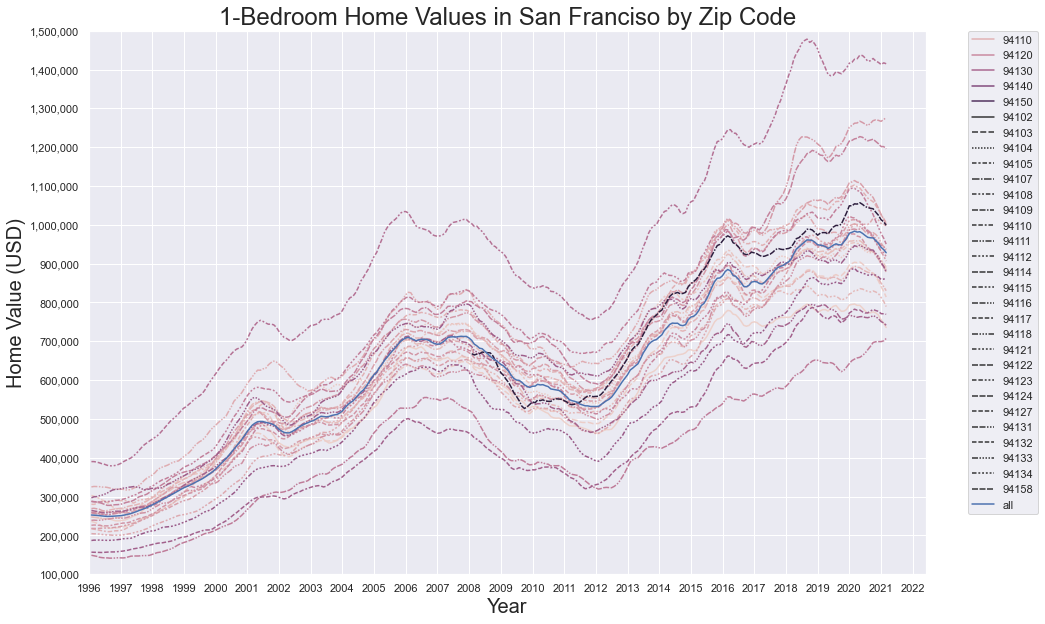

In [177]:
visualize_data(df_1, sf_1_all, 1)

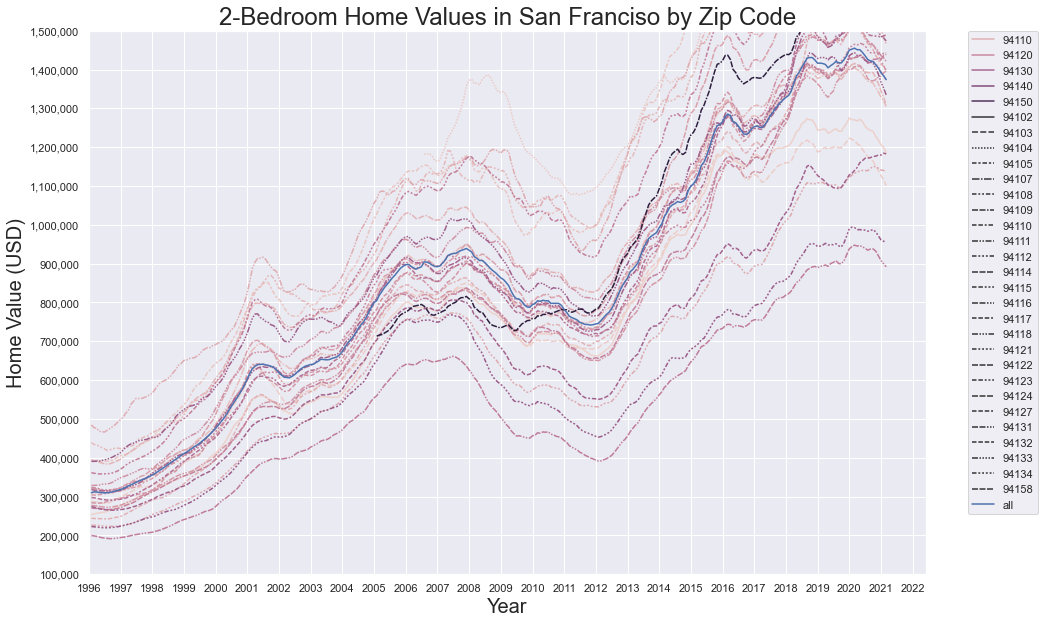

In [176]:
visualize_data(df_2, sf_2_all, 2)

# Data Prep

## Prepare Data Structures

Create dictionary data structures with `keys` as zip codes and `values` as time series DataFrames.

In [77]:
sf_1_dict = create_df_dict(df_1)
sf_2_dict = create_df_dict(df_2)

In [78]:
sf_1_dict;

In [79]:
sf_2_dict;

## Test Stationarity

### 1-Bedroom Home Values

Test stationarity for 1-bedroom home values, undifferenced. We see that the p-value is above 0.05, meaning this does not pass the test.

In [80]:
test_stationarity(sf_1_all)

Test Statistic                  -1.793011
p-value                          0.383937
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 1-bedroom home values, differenced once. We see that the p-value is still above 0.05.

In [81]:
test_stationarity(sf_1_all, 1)

Test Statistic                  -2.316876
p-value                          0.166583
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 1-bedroom home values, differenced twice. We see that the p-value is below 0.05, which passes the test.

In [82]:
test_stationarity(sf_1_all, 2)

Test Statistic                -7.097080e+00
p-value                        4.261762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


Check that all zip codes pass the test if differenced twice.

In [83]:
test_stationarity_all_zips(sf_1_dict, 2)

1.0599778975079152e-10
3.741464132790946e-09
2.3729847439580716e-06
2.0929714720663458e-08
1.0200049818308661e-08
8.756177530210159e-09
1.0585564028994617e-10
2.8366739299059573e-11
1.8755930836472323e-08
2.983599222687353e-06
1.4626119295937968e-05
4.984964071457166e-11
1.4867341484506552e-12
1.3012300113850876e-10
1.3349107506832198e-13
2.5766985124870837e-06
3.304531327481468e-11
4.84227162460841e-06
6.533571835152499e-08
1.2275721154980474e-11
2.394469222712887e-10
5.3200248248897185e-06
1.8117342866285599e-09
2.2700159189322e-09
6.443921226583154e-06


### 2-Bedroom Home Values

Test stationarity for 2-bedroom home values, undifferenced. We see that the p-value is above 0.05, meaning this does not pass the test.

In [84]:
test_stationarity(sf_2_all)

Test Statistic                  -1.400165
p-value                          0.582197
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 2-bedroom home values, differenced once. We see that the p-value is still above 0.05.

In [85]:
test_stationarity(sf_2_all, 1)

Test Statistic                  -2.425809
p-value                          0.134584
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 2-bedroom home values, differenced twice. We see that the p-value is below 0.05, which passes the test.

In [86]:
test_stationarity(sf_2_all, 2) 

Test Statistic                -6.661065e+00
p-value                        4.845806e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


Check that all zip codes pass the test if differenced twice.

In [87]:
test_stationarity_all_zips(sf_2_dict, 2)

2.8382629098311306e-10
4.105094397739434e-10
0.0001036199036005712
0.00026676677750230124
2.3473022836333186e-08
3.3335544220559767e-10
2.6545006217420434e-09
0.00026771357306753607
4.956780761113351e-06
2.716569237155872e-10
3.2762403314473923e-10
1.84499064469341e-11
2.296287426065445e-11
6.379337366664813e-12
6.65319394872682e-13
1.731984377391829e-05
1.3969195940414835e-09
6.410154732169535e-11
1.2892163548319115e-05
1.3300093369712271e-09
6.493273247722747e-11
1.3110838236452227e-08
8.47697643344506e-09
1.4133134873087657e-07
3.356775496920719e-08


## Plot ACF and PACF

### 1-Bedroom Home Values

Plot Partial Autocorrelation with undifferenced and differenced data. This suggests an AR term of up to 2.

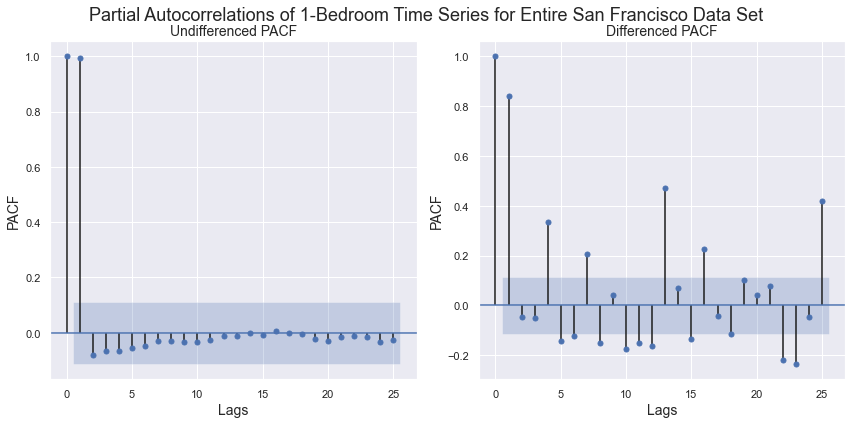

In [88]:
plot_pacf_housing(sf_1_all, 1)

Plot Autocorrelation with undifferenced, once-differenced, and twice-differenced data. This suggests MA terms of up to 2, and difference term of 2.

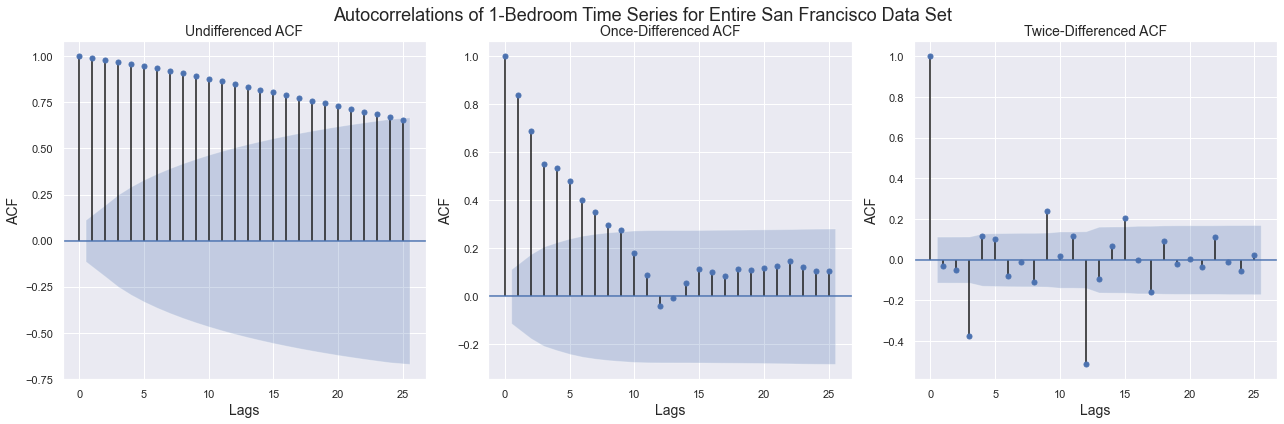

In [98]:
plot_acf_housing(sf_1_all, 1)

### 2-Bedroom Home Values

Plot Partial Autocorrelation with undifferenced and differenced data. This suggests an AR term of up to 2.

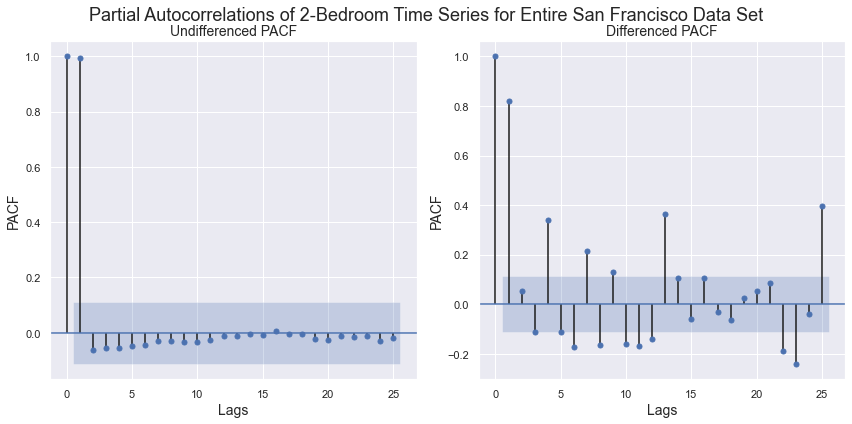

In [90]:
plot_pacf_housing(sf_2_all, 2)

Plot Autocorrelation with undifferenced, once-differenced, and twice-differenced data. This suggests MA terms of up to 2, and difference term of 2.

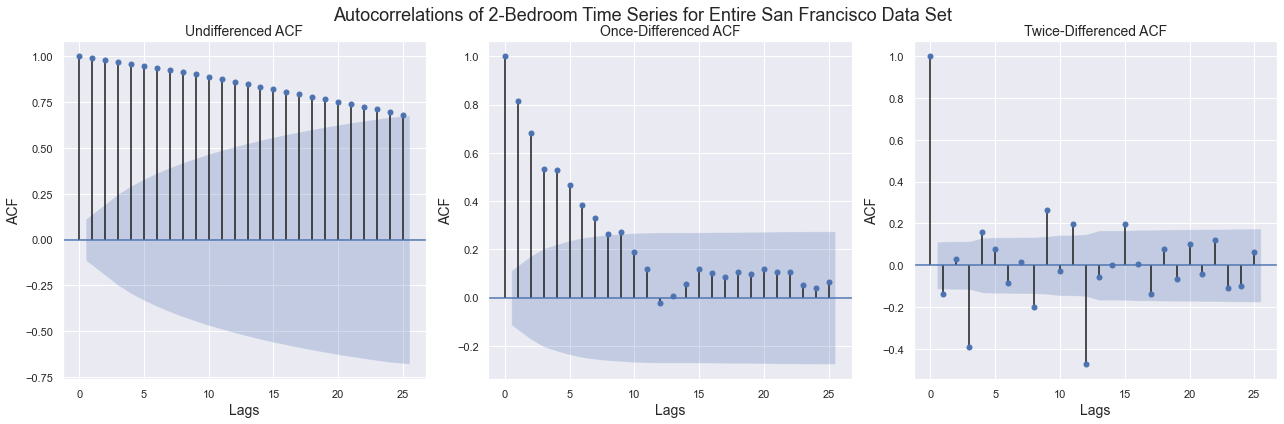

In [99]:
plot_acf_housing(sf_2_all, 2)

## Plot Seasonal Decomposition

### 1-Bedroom Home Values

Plot seasonal decompositions of our 1-bedroom home values. We see a rising trend and 12-month seasonality.

Functions loaded.


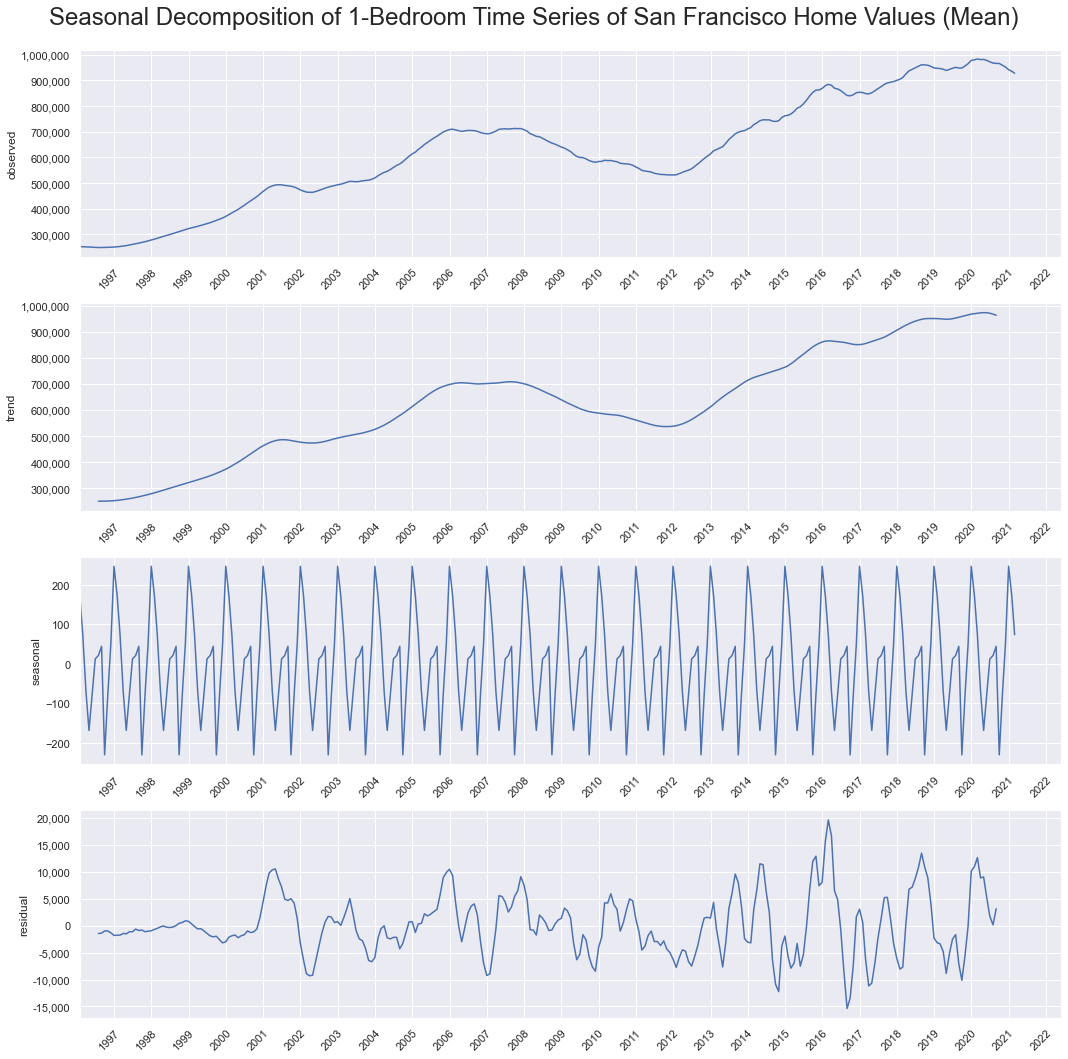

In [166]:
plot_seasonal_decomposition(sf_1_all, 1)

### 2-Bedroom Home Values

Plot seasonal decompositions of our 2-bedroom home values. We see a rising trend and 12-month seasonality.

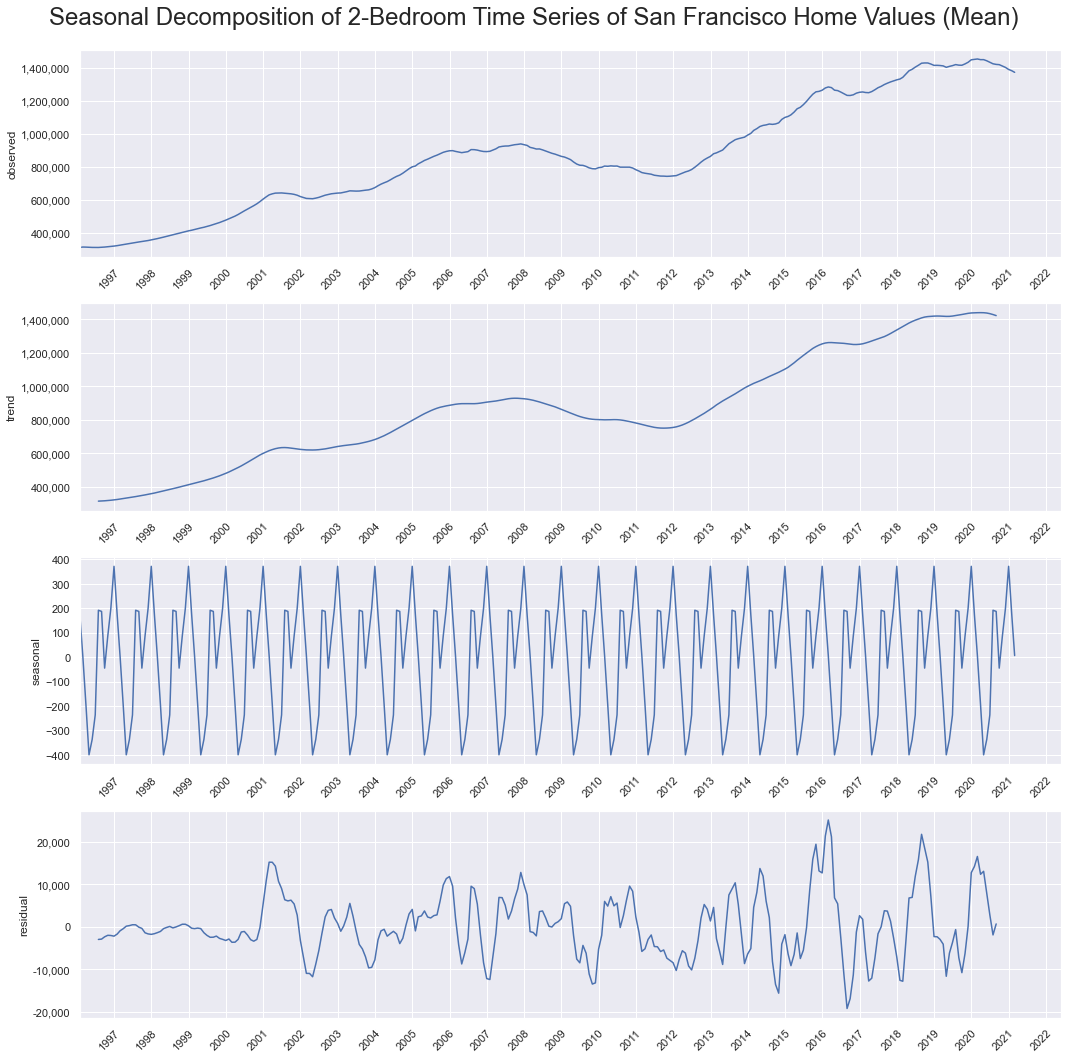

In [167]:
plot_seasonal_decomposition(sf_2_all, 2)

# SARIMAX Modeling

## Perform Train-Test Split

Perform a train-test split using `84/16` split. Chosen to give the most recent 4 years as test set.  
Also tested with `76/24` (6 years test set) and `80/20` (5 years test set), but `84/16` gave the best RMSEs.

In [94]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict, 84)
sf_2_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict, 84)

Using a 84/16 train-test split...
Using a 84/16 train-test split...


## Manual GridSearch of Model Parameters

Test p, d, q ranging from 0 to 3 for both ARIMA and SARIMA parameters, differenced 1 or 2 times, with 12 month seasonality; print AIC. Showing results for best model only.

In [123]:
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_1_train_dict)

Functions loaded.
Parameters for SARIMAX grid search...
SARIMAX: (2, 1, 0) x (2, 1, 0, 12)
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94102 | AIC: 4304.602116888669
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94103 | AIC: 4271.650718310228
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94104 | AIC: 2344.4694453550946
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94105 | AIC: 4423.517827811545
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94107 | AIC: 4325.720690312978
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94108 | AIC: 4501.825620207042
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94109 | AIC: 4330.374357152814
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94110 | AIC: 4306.6450648436385
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94111 | AIC: 4479.423245302584
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94112 | AIC: 4145.84338056434
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94114 | AIC: 4378.484641762236
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94115 | AIC: 4340.292756368761
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94116 | AIC: 4172.391699141797
(2, 1, 0) (2, 1, 0, 12)
Zip Code 94117 | AIC: 4372.251674576593
(2, 1, 0) (2

Based on our tests, we found the best parameters are ARIMA (2, 1, 0) x SARIMA (2, 1, 0, 12),  
and the AICs are mostly in the low 4000s.

In [96]:
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)

Functions loaded.
             param param_seasonal          aic
zipcode                                       
94102    (2, 1, 0)  (2, 1, 0, 12)  4188.517946
94103    (2, 1, 0)  (2, 1, 0, 12)  4147.122113
94104    (2, 1, 0)  (2, 1, 0, 12)  3077.917616
94105    (2, 1, 0)  (2, 1, 0, 12)  4200.317363
94107    (2, 1, 0)  (2, 1, 0, 12)  4121.471585
94108    (2, 1, 0)  (2, 1, 0, 12)  4197.293676
94109    (2, 1, 0)  (2, 1, 0, 12)  4124.395869
94110    (2, 1, 0)  (2, 1, 0, 12)  4223.484332
94111    (2, 1, 0)  (2, 1, 0, 12)  4304.357094
94112    (2, 1, 0)  (2, 1, 0, 12)  4140.321303
94114    (2, 1, 0)  (2, 1, 0, 12)  4265.450160
94115    (2, 1, 0)  (2, 1, 0, 12)  4175.763239
94116    (2, 1, 0)  (2, 1, 0, 12)  4151.111305
94117    (2, 1, 0)  (2, 1, 0, 12)  4174.052275
94118    (2, 1, 0)  (2, 1, 0, 12)  4210.341257
94121    (2, 1, 0)  (2, 1, 0, 12)  4226.824080
94122    (2, 1, 0)  (2, 1, 0, 12)  4239.316663
94123    (2, 1, 0)  (2, 1, 0, 12)  4184.688371
94124    (2, 1, 0)  (2, 1, 0, 12)  4068.41

In [97]:
sf_1_best_df

param param_seasonal          aic
zipcode                                       
94102    (2, 1, 0)  (2, 1, 0, 12)  4188.517946
94103    (2, 1, 0)  (2, 1, 0, 12)  4147.122113
94104    (2, 1, 0)  (2, 1, 0, 12)  3077.917616
94105    (2, 1, 0)  (2, 1, 0, 12)  4200.317363
94107    (2, 1, 0)  (2, 1, 0, 12)  4121.471585
94108    (2, 1, 0)  (2, 1, 0, 12)  4197.293676
94109    (2, 1, 0)  (2, 1, 0, 12)  4124.395869
94110    (2, 1, 0)  (2, 1, 0, 12)  4223.484332
94111    (2, 1, 0)  (2, 1, 0, 12)  4304.357094
94112    (2, 1, 0)  (2, 1, 0, 12)  4140.321303
94114    (2, 1, 0)  (2, 1, 0, 12)  4265.450160
94115    (2, 1, 0)  (2, 1, 0, 12)  4175.763239
94116    (2, 1, 0)  (2, 1, 0, 12)  4151.111305
94117    (2, 1, 0)  (2, 1, 0, 12)  4174.052275
94118    (2, 1, 0)  (2, 1, 0, 12)  4210.341257
94121    (2, 1, 0)  (2, 1, 0, 12)  4226.824080
94122    (2, 1, 0)  (2, 1, 0, 12)  4239.316663
94123    (2, 1, 0)  (2, 1, 0, 12)  4184.688371
94124    (2, 1, 0)  (2, 1, 0, 12)  4068.412466
94127    (2, 1, 0)  (2, 1, 0, 12)  4321.168809
94131    (2, 1, 0)  (2, 1, 0, 12)  4183.903729
94132    (2, 1, 0)  (2, 1, 0, 12)  4018.578560
94133    (2, 1, 0)  (2, 1, 0, 12)  4195.487196
94134    (2, 1, 0)  (2, 1, 0, 12)  4095.279489
94158    (2, 1, 0)  (2, 1, 0, 12)  1890.625650

In [100]:
sf_2_best_df

param param_seasonal          aic
zipcode                                       
94102    (2, 1, 0)  (2, 1, 0, 12)  4188.517946
94103    (2, 1, 0)  (2, 1, 0, 12)  4147.122113
94104    (2, 1, 0)  (2, 1, 0, 12)  3077.917616
94105    (2, 1, 0)  (2, 1, 0, 12)  4200.317363
94107    (2, 1, 0)  (2, 1, 0, 12)  4121.471585
94108    (2, 1, 0)  (2, 1, 0, 12)  4197.293676
94109    (2, 1, 0)  (2, 1, 0, 12)  4124.395869
94110    (2, 1, 0)  (2, 1, 0, 12)  4223.484332
94111    (2, 1, 0)  (2, 1, 0, 12)  4304.357094
94112    (2, 1, 0)  (2, 1, 0, 12)  4140.321303
94114    (2, 1, 0)  (2, 1, 0, 12)  4265.450160
94115    (2, 1, 0)  (2, 1, 0, 12)  4175.763239
94116    (2, 1, 0)  (2, 1, 0, 12)  4151.111305
94117    (2, 1, 0)  (2, 1, 0, 12)  4174.052275
94118    (2, 1, 0)  (2, 1, 0, 12)  4210.341257
94121    (2, 1, 0)  (2, 1, 0, 12)  4226.824080
94122    (2, 1, 0)  (2, 1, 0, 12)  4239.316663
94123    (2, 1, 0)  (2, 1, 0, 12)  4184.688371
94124    (2, 1, 0)  (2, 1, 0, 12)  4068.412466
94127    (2, 1, 0)  (2, 1, 0, 12)  4321.168809
94131    (2, 1, 0)  (2, 1, 0, 12)  4183.903729
94132    (2, 1, 0)  (2, 1, 0, 12)  4018.578560
94133    (2, 1, 0)  (2, 1, 0, 12)  4195.487196
94134    (2, 1, 0)  (2, 1, 0, 12)  4095.279489
94158    (2, 1, 0)  (2, 1, 0, 12)  1890.625650

## Evaluate Model

Using an step-wise test vs prediction function, perform a grid search of SARIMAX paramters to evaluate the model using RMSE scores.

In [109]:
zipcodes_1, param_1_list, param_1_seasonal_list, RMSE_1_list = gridsearch_SARIMAX_test_predict(sf_1_train_dict, sf_1_test_dict)
zipcodes_2, param_2_list, param_2_seasonal_list, RMSE_2_list = gridsearch_SARIMAX_test_predict(sf_1_train_dict, sf_2_test_dict)

Functions loaded.
Parameters for SARIMAX grid search for test predictions...
SARIMAX: (2, 1, 0) x (2, 1, 0, 12)
--------------------------Completed.
Parameters for SARIMAX grid search for test predictions...
SARIMAX: (2, 1, 0) x (2, 1, 0, 12)
--------------------------Completed.


Using an step-wise test vs prediction function, evaluate best model.

In [110]:
sf_1_pred_dict = evaluate_model(sf_1_train_dict, sf_1_test_dict, sf_1_best_df)
sf_2_pred_dict = evaluate_model(sf_2_train_dict, sf_2_test_dict, sf_2_best_df)

---------------------------------------------------------------------------------------------------
Completed.
--------------------------------------------------------------------------------------------------
Completed.


Create a dataframe of RMSE scores for 1-bedroom and 2-bedroom home values.

In [46]:
RMSE_1_df = calc_RMSE(sf_1_test_dict, sf_1_pred_dict, 1)
RMSE_2_df = calc_RMSE(sf_2_test_dict, sf_2_pred_dict, 2)

Create visualizations of observations vs predictions for each zip code.

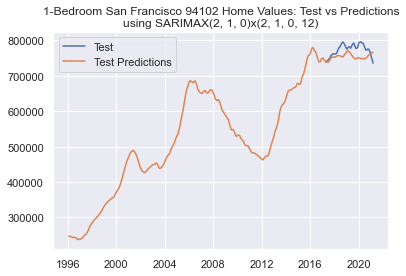

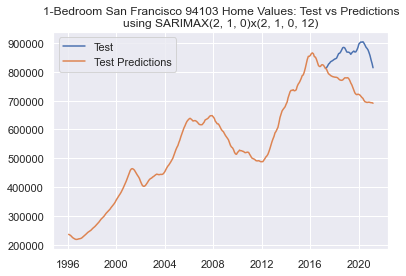

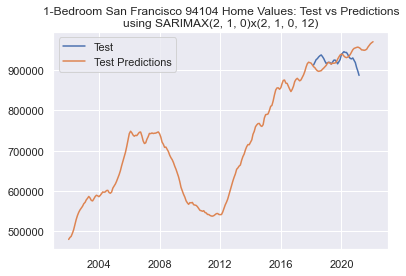

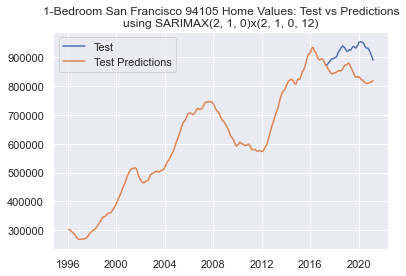

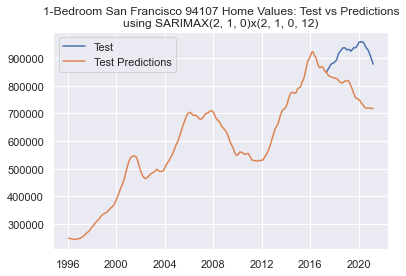

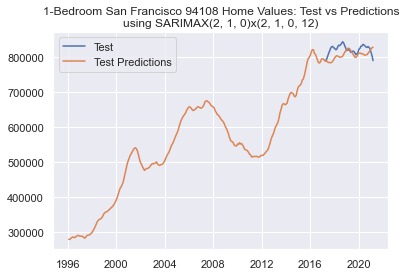

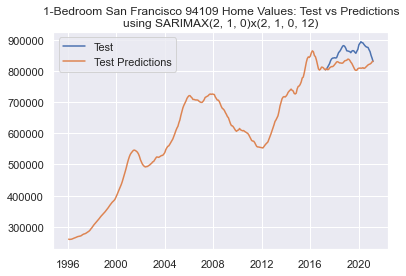

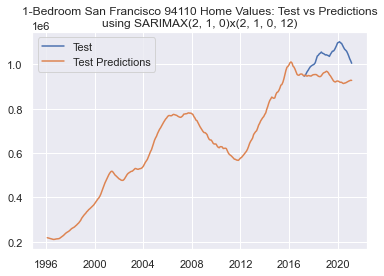

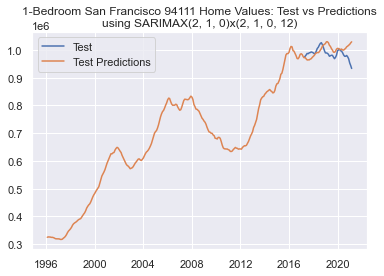

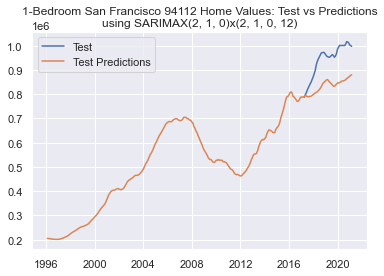

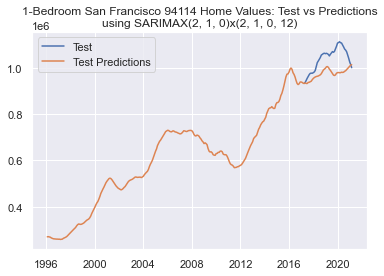

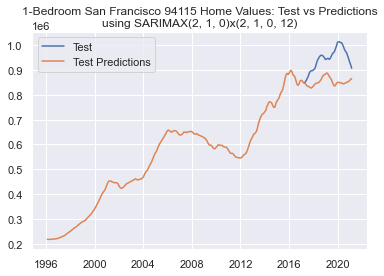

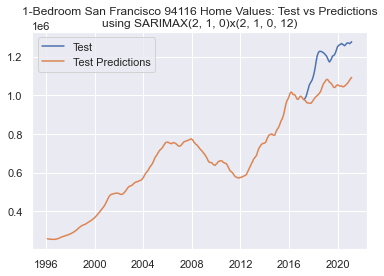

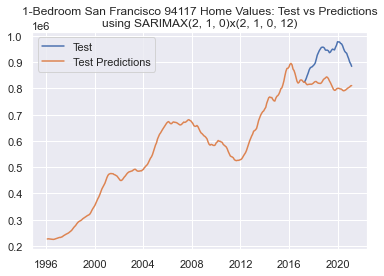

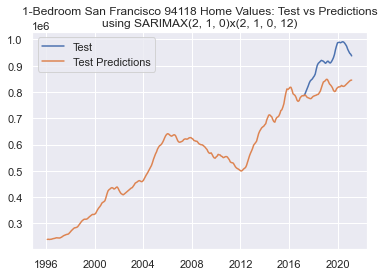

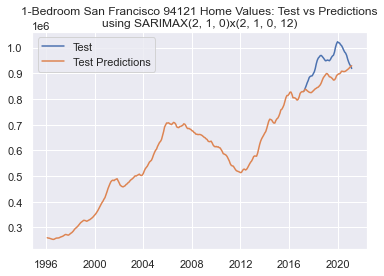

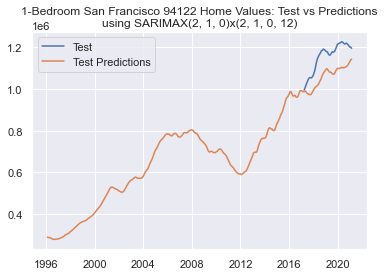

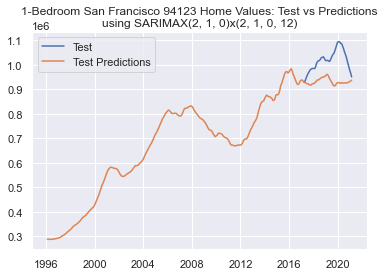

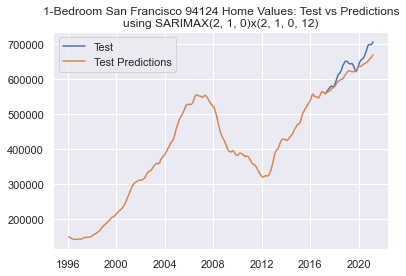

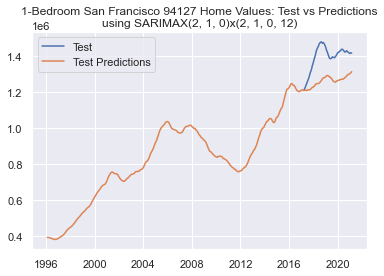

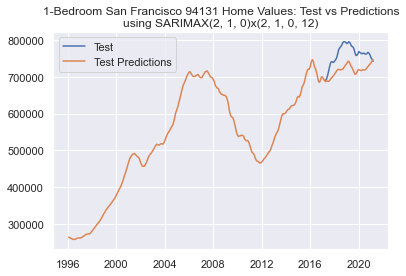

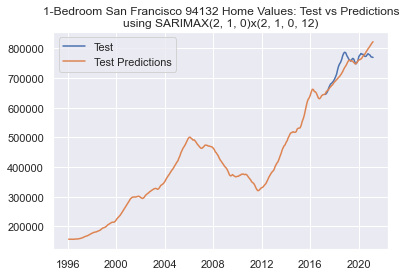

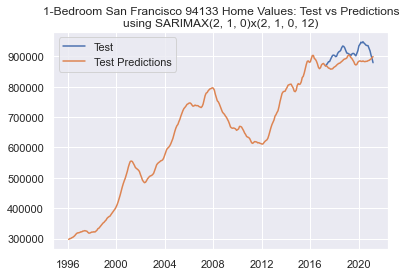

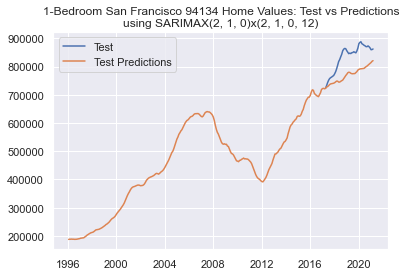

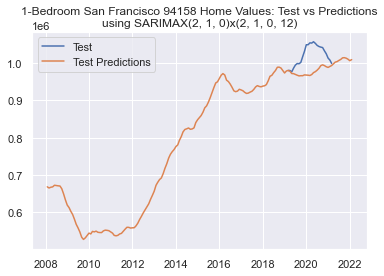

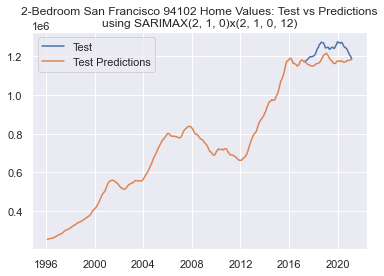

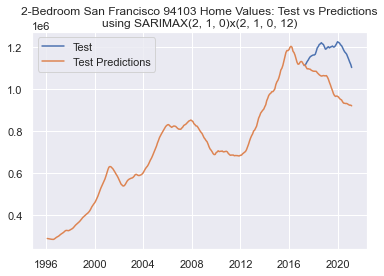

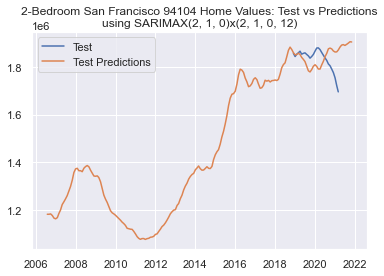

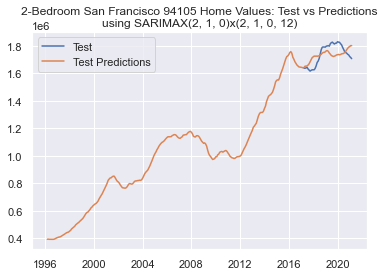

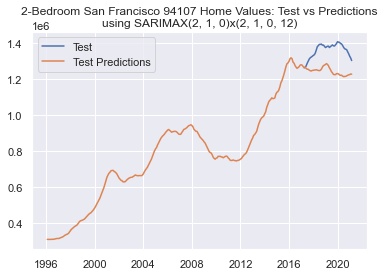

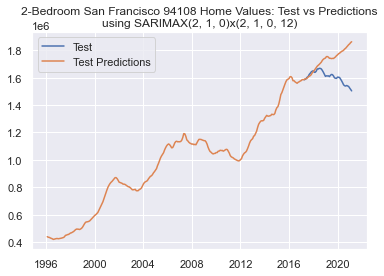

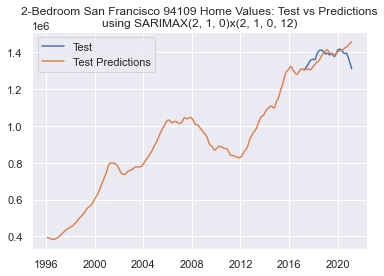

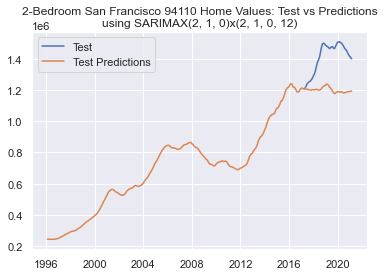

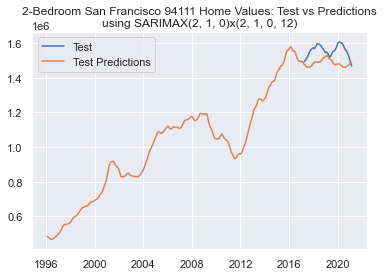

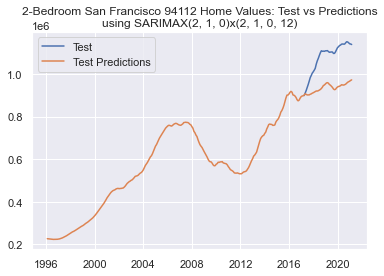

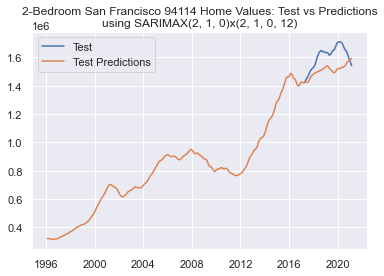

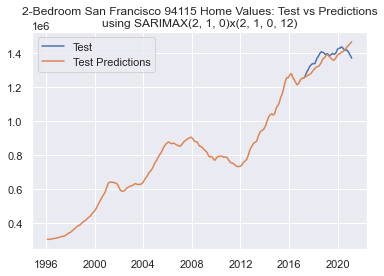

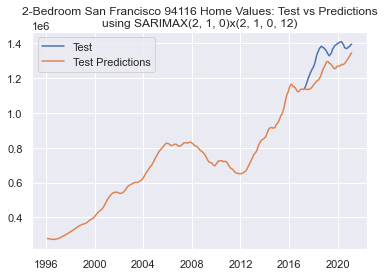

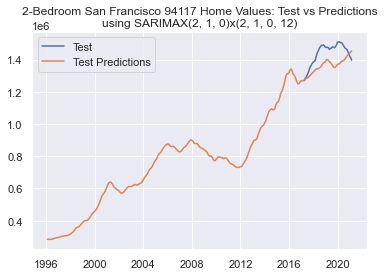

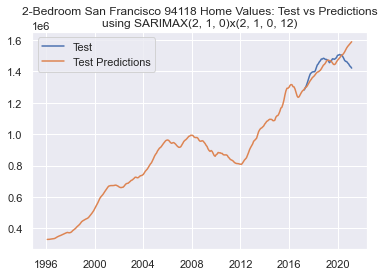

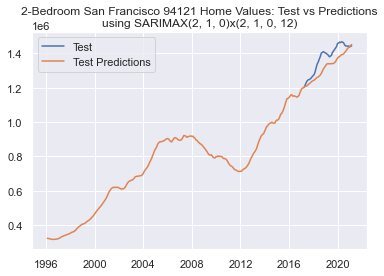

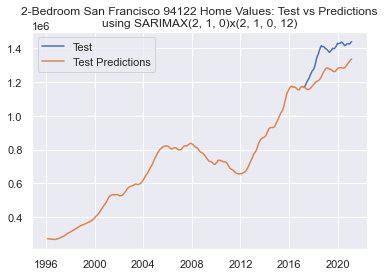

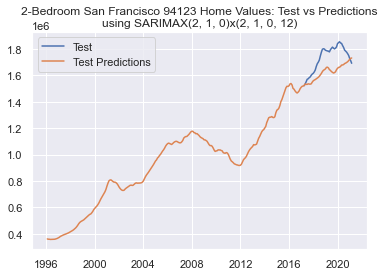

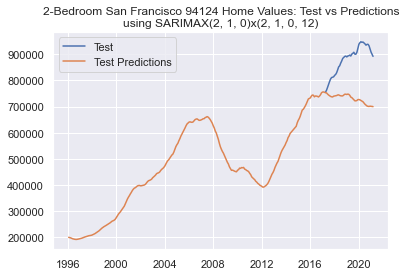

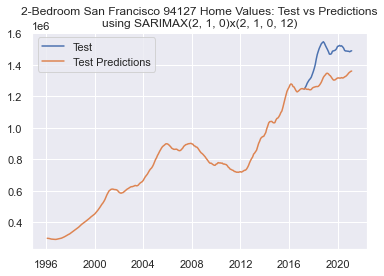

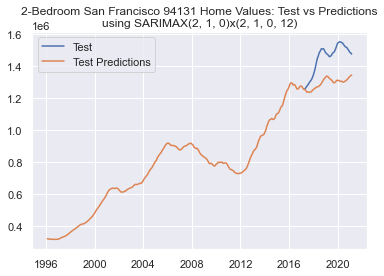

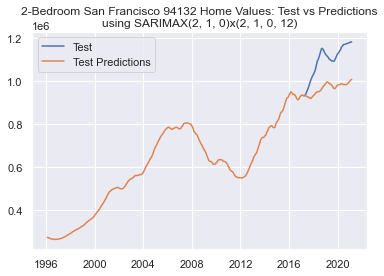

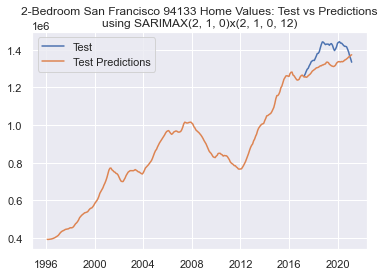

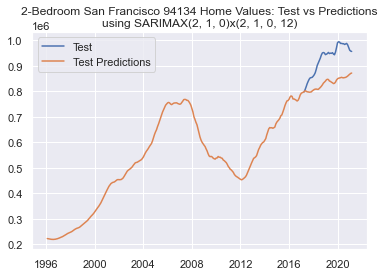

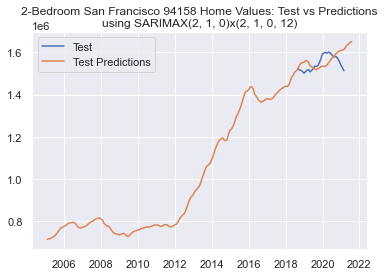

In [47]:
plot_train_test(sf_1_test_dict, sf_1_pred_dict, sf_1_best_df, 1)
plot_train_test(sf_2_test_dict, sf_2_pred_dict, sf_2_best_df, 2)

Plot RMSE scores as well as RMSE as a percentage of most recent home value observation. We see that RMSE ranges from 2% to 15% of home values.

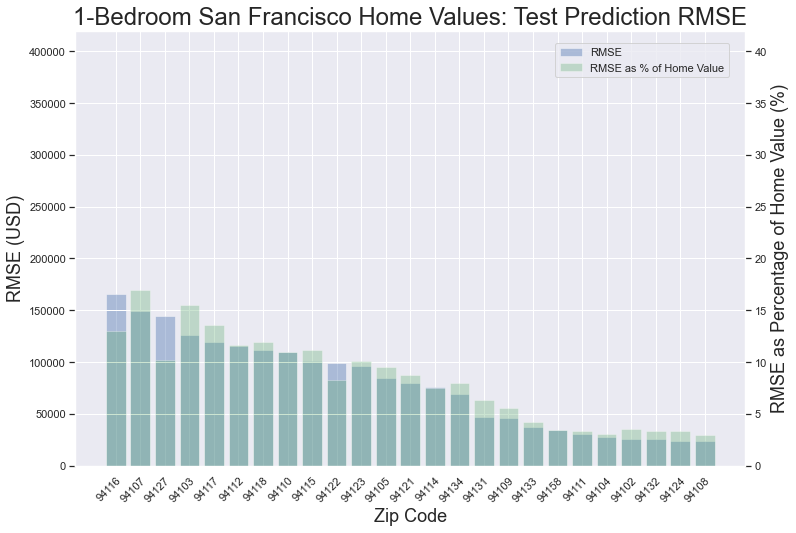

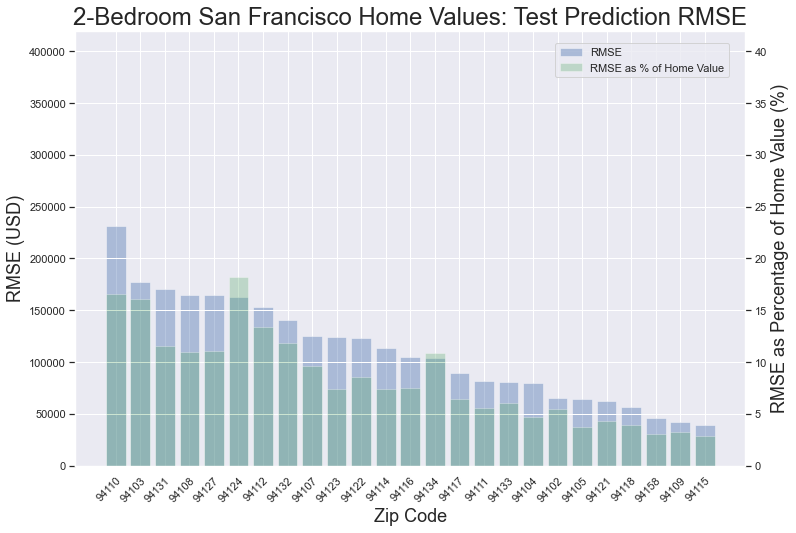

In [48]:
plot_RMSE(RMSE_1_df, 1)
plot_RMSE(RMSE_2_df, 2)

## Run Forecast

Forecast 12 months into the future using our SARIMAX best parameters.

In [152]:
sf_1_best_df

param param_seasonal          aic
zipcode                                       
94102    (2, 1, 0)  (2, 1, 0, 12)  4188.517946
94103    (2, 1, 0)  (2, 1, 0, 12)  4147.122113
94104    (2, 1, 0)  (2, 1, 0, 12)  3077.917616
94105    (2, 1, 0)  (2, 1, 0, 12)  4200.317363
94107    (2, 1, 0)  (2, 1, 0, 12)  4121.471585
94108    (2, 1, 0)  (2, 1, 0, 12)  4197.293676
94109    (2, 1, 0)  (2, 1, 0, 12)  4124.395869
94110    (2, 1, 0)  (2, 1, 0, 12)  4223.484332
94111    (2, 1, 0)  (2, 1, 0, 12)  4304.357094
94112    (2, 1, 0)  (2, 1, 0, 12)  4140.321303
94114    (2, 1, 0)  (2, 1, 0, 12)  4265.450160
94115    (2, 1, 0)  (2, 1, 0, 12)  4175.763239
94116    (2, 1, 0)  (2, 1, 0, 12)  4151.111305
94117    (2, 1, 0)  (2, 1, 0, 12)  4174.052275
94118    (2, 1, 0)  (2, 1, 0, 12)  4210.341257
94121    (2, 1, 0)  (2, 1, 0, 12)  4226.824080
94122    (2, 1, 0)  (2, 1, 0, 12)  4239.316663
94123    (2, 1, 0)  (2, 1, 0, 12)  4184.688371
94124    (2, 1, 0)  (2, 1, 0, 12)  4068.412466
94127    (2, 1, 0)  (2, 1, 0, 12)  4321.168809
94131    (2, 1, 0)  (2, 1, 0, 12)  4183.903729
94132    (2, 1, 0)  (2, 1, 0, 12)  4018.578560
94133    (2, 1, 0)  (2, 1, 0, 12)  4195.487196
94134    (2, 1, 0)  (2, 1, 0, 12)  4095.279489
94158    (2, 1, 0)  (2, 1, 0, 12)  1890.625650

Functions loaded.


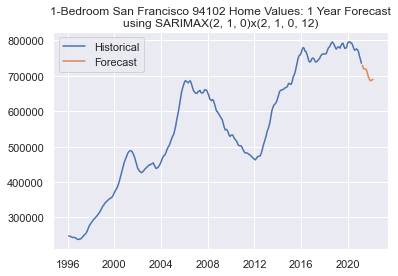

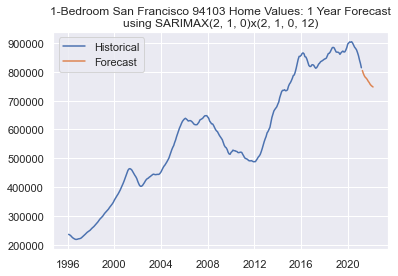

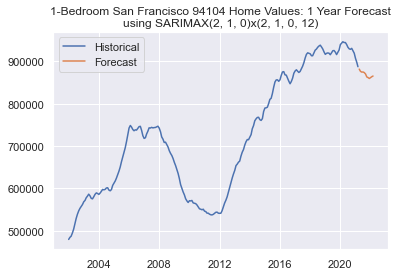

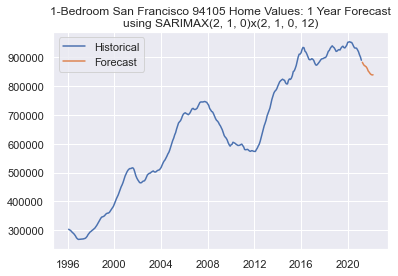

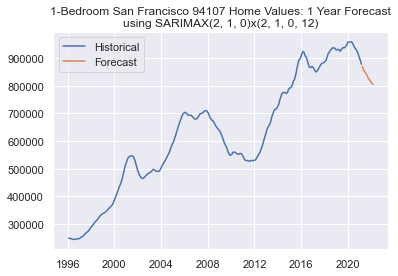

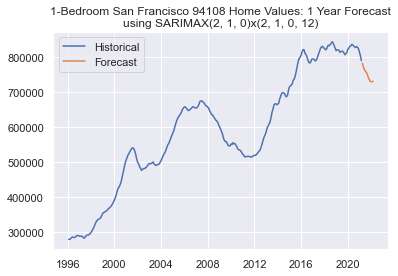

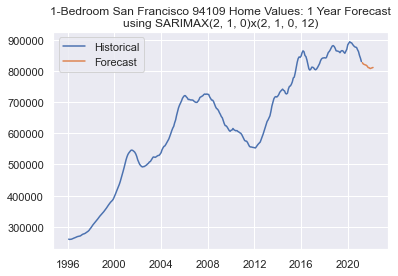

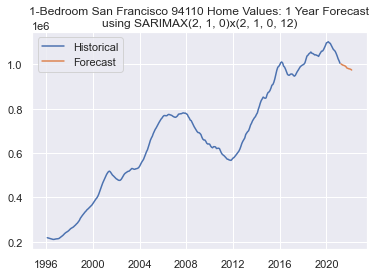

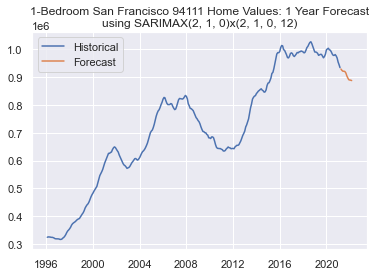

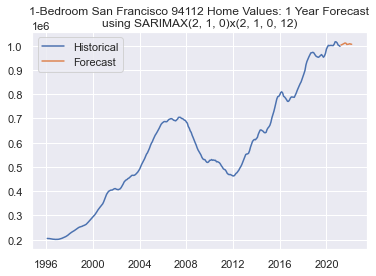

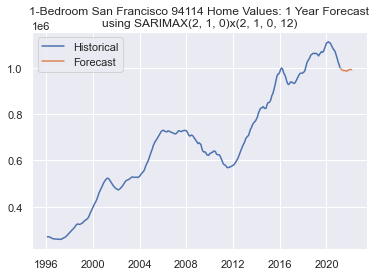

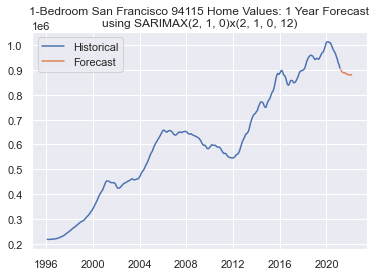

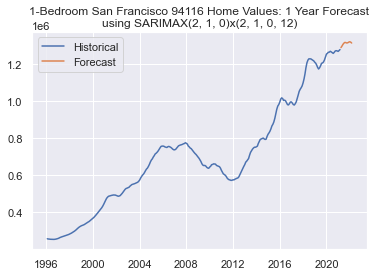

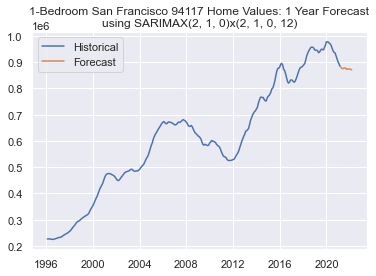

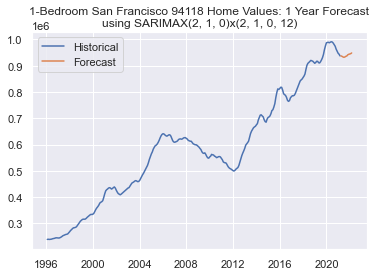

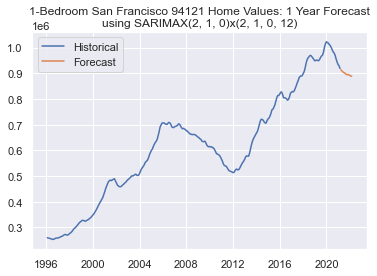

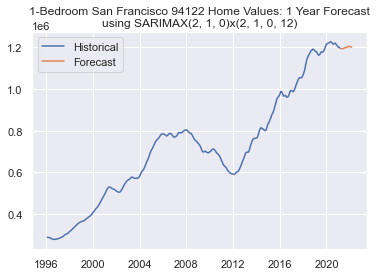

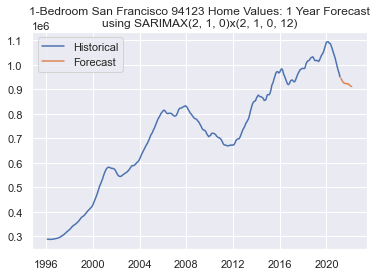

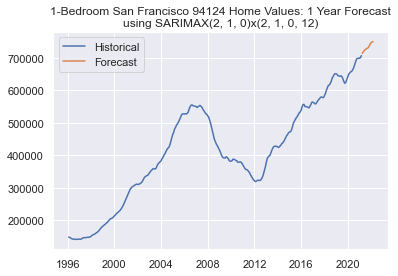

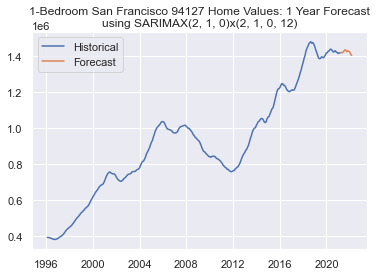

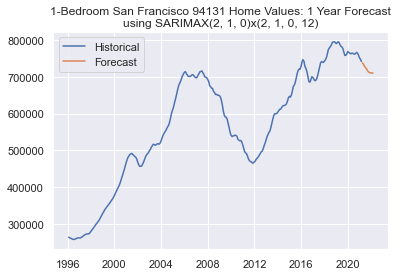

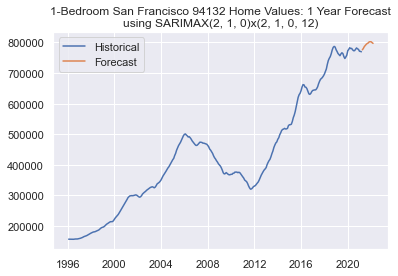

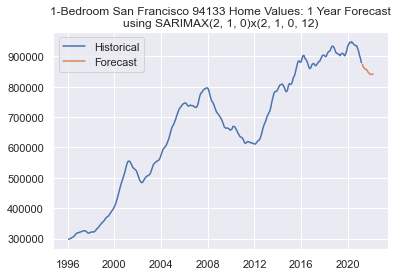

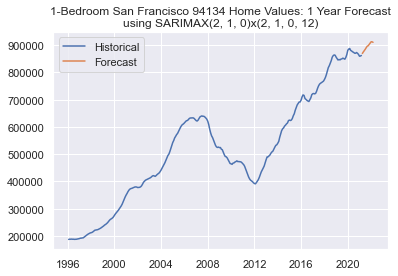

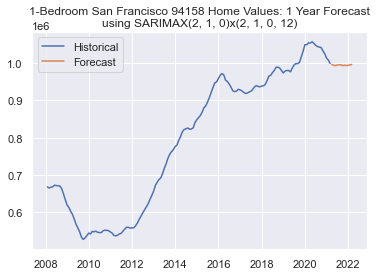

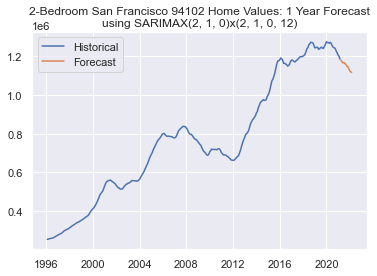

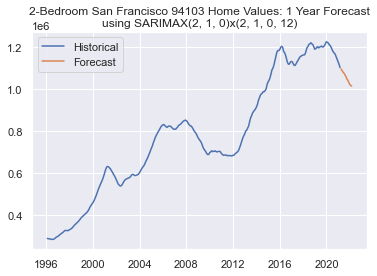

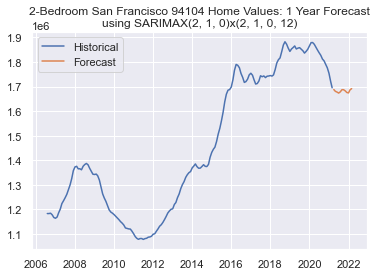

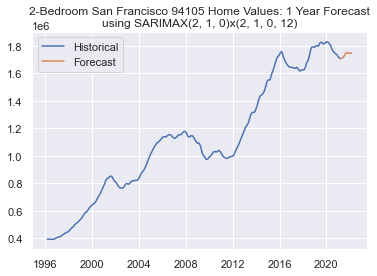

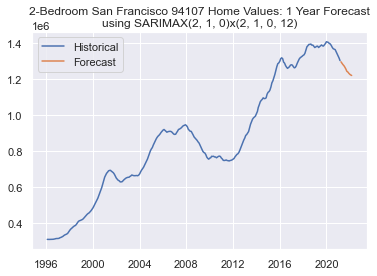

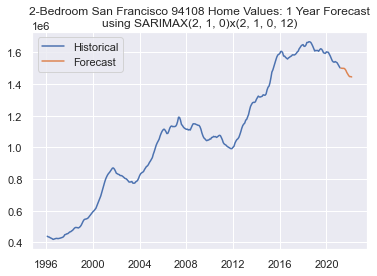

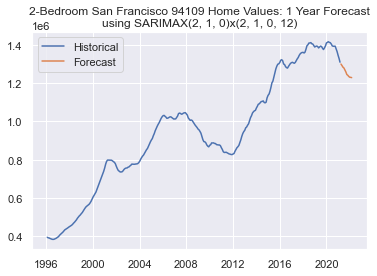

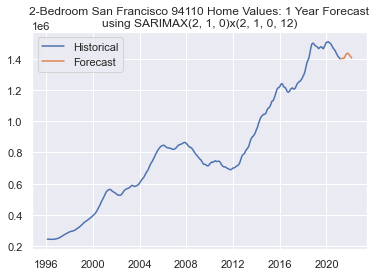

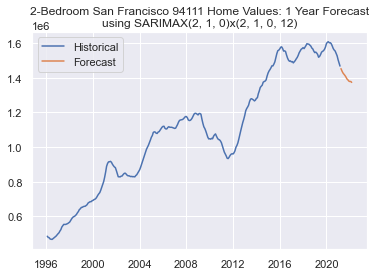

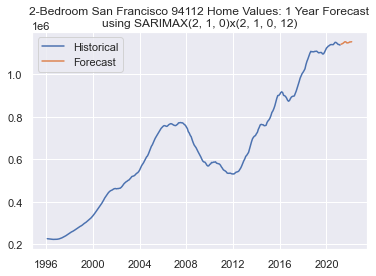

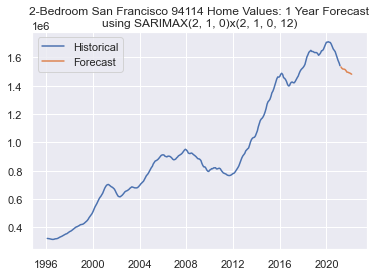

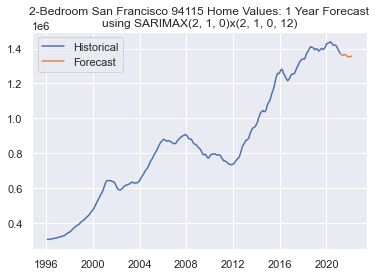

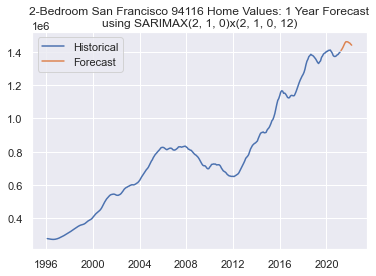

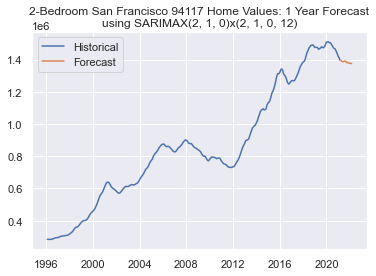

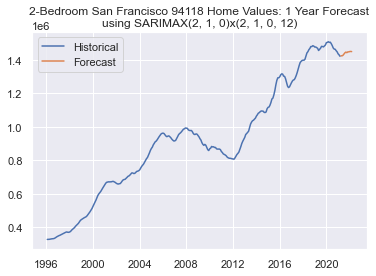

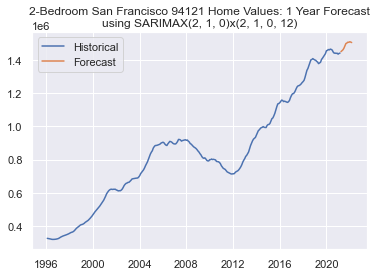

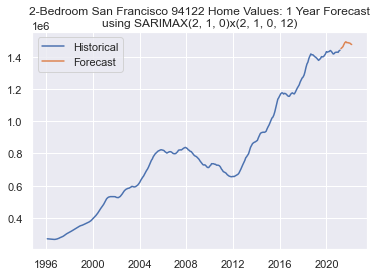

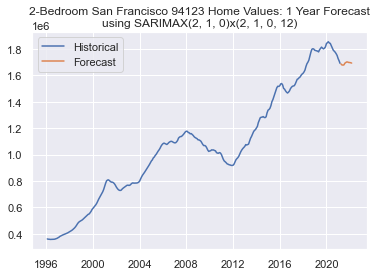

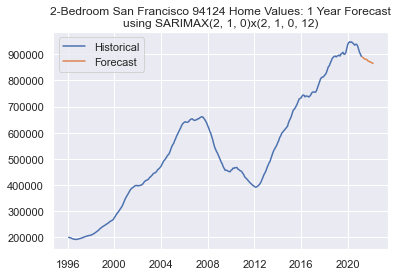

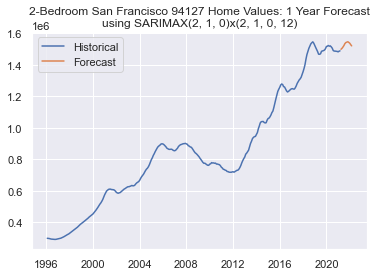

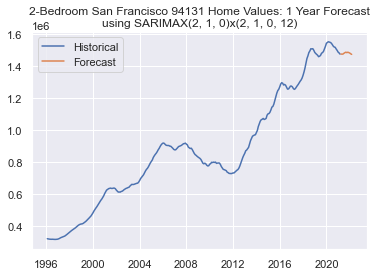

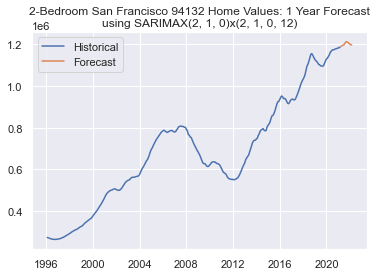

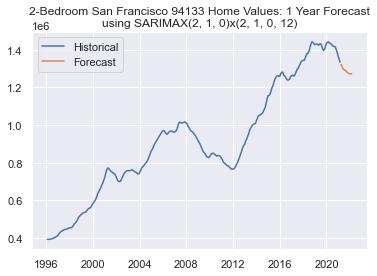

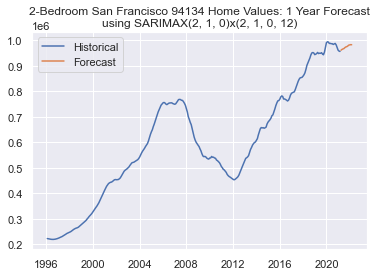

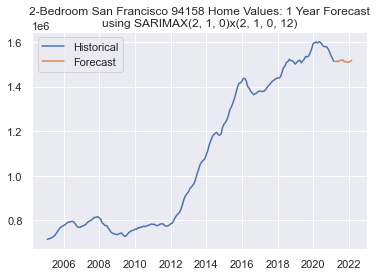

In [162]:
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df, 1)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df, 2)

In [155]:
sf_1_forecast_df = pd.concat(list(sf_1_forecast_dict.values()), axis=0)
sf_2_forecast_df = pd.concat(list(sf_2_forecast_dict.values()), axis=0)

# Results

Create final DataFrames of zip codes, most recent observation, forecasted value 12 months in the future, and the forecasted percent change.

In [51]:
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)

In [52]:
sf_1_sorted_df

current_value  forecasted_value  percent_change
zipcode                                                 
94107         878670.0      8.049621e+05           -8.39
94103         814072.0      7.474128e+05           -8.19
94108         789435.0      7.306020e+05           -7.45
94102         735521.0      6.898944e+05           -6.20
94105         889936.0      8.393263e+05           -5.69
94111         933245.0      8.867922e+05           -4.98
94133         878883.0      8.412188e+05           -4.29
94131         741362.0      7.099067e+05           -4.24
94123         950376.0      9.112567e+05           -4.12
94121         918498.0      8.883339e+05           -3.28
94110        1005398.0      9.748165e+05           -3.04
94115         906629.0      8.803418e+05           -2.90
94104         887025.0      8.649896e+05           -2.48
94109         830373.0      8.112180e+05           -2.31
94117         883598.0      8.705449e+05           -1.48
94114        1001836.0      9.923508e+05           -0.95
94127        1414935.0      1.402715e+06           -0.86
94158         998991.0      9.961101e+05           -0.29
94122        1195832.0      1.201394e+06            0.47
94112         997912.0      1.006700e+06            0.88
94118         937447.0      9.485550e+05            1.18
94116        1276358.0      1.311521e+06            2.75
94132         769590.0      7.970283e+05            3.57
94134         862181.0      9.105612e+05            5.61
94124         707290.0      7.499215e+05            6.03

In [53]:
sf_2_sorted_df

current_value  forecasted_value  percent_change
zipcode                                                 
94103        1100702.0      1.012917e+06           -7.98
94111        1466530.0      1.372397e+06           -6.42
94107        1304574.0      1.221666e+06           -6.36
94109        1308934.0      1.228338e+06           -6.16
94102        1185630.0      1.117290e+06           -5.76
94133        1334650.0      1.271717e+06           -4.72
94114        1541337.0      1.481241e+06           -3.90
94108        1502923.0      1.445123e+06           -3.85
94124         891894.0      8.644765e+05           -3.07
94117        1395879.0      1.374520e+06           -1.53
94115        1372370.0      1.355927e+06           -1.20
94104        1695012.0      1.691377e+06           -0.21
94131        1473693.0      1.471990e+06           -0.12
94123        1689377.0      1.690839e+06            0.09
94158        1513017.0      1.517714e+06            0.31
94110        1398923.0      1.404547e+06            0.40
94132        1182842.0      1.195826e+06            1.10
94112        1137737.0      1.153424e+06            1.38
94118        1421186.0      1.449156e+06            1.97
94127        1488832.0      1.520767e+06            2.14
94105        1706714.0      1.745648e+06            2.28
94122        1439525.0      1.474904e+06            2.46
94134         956182.0      9.823915e+05            2.74
94116        1395930.0      1.438781e+06            3.07
94121        1443658.0      1.507367e+06            4.41

Display top 3 zip codes where investment may grow the most, for 1-bedroom and 2-bedroom home values.

In [54]:
best_3_zipcodes(sf_1_sorted_df, 1)
best_3_zipcodes(sf_2_sorted_df, 2)

The zipcodes with the greatest projected growth in mid-tier 1-bedroom home values are:
current_value       769590.000000
forecasted_value    797028.329971
percent_change           3.570000
Name: 94132, dtype: float64
 current_value       862181.000000
forecasted_value    910561.218251
percent_change           5.610000
Name: 94134, dtype: float64
 current_value       707290.000000
forecasted_value    749921.460062
percent_change           6.030000
Name: 94124, dtype: float64
The zipcodes with the greatest projected growth in mid-tier 2-bedroom home values are:
current_value       956182.000000
forecasted_value    982391.538238
percent_change           2.740000
Name: 94134, dtype: float64
 current_value       1.395930e+06
forecasted_value    1.438781e+06
percent_change      3.070000e+00
Name: 94116, dtype: float64
 current_value       1.443658e+06
forecasted_value    1.507367e+06
percent_change      4.410000e+00
Name: 94121, dtype: float64


Zip code `94124` for 1-bedroom homes showed the greatest projected growth in a year, about 6%.  
For 2-bedroom homes, `94121` has the greatest projected growth in a year, 4.4%.

It is interesting to note that `94124` currently has the lowest prices for San Francisco 1-bedroom homes. According to the model, in a year's time this zip code will be ranked 5th lowest in price out of the 25 zip codes.

By contrast, `94121` currently has the 10th highest prices for San Francisco 2-bedroom homes. According to our model, this zip code will move up to the 6th rank in a year.

## Visualizations

Show graph of growth forecasts for all zip codes.

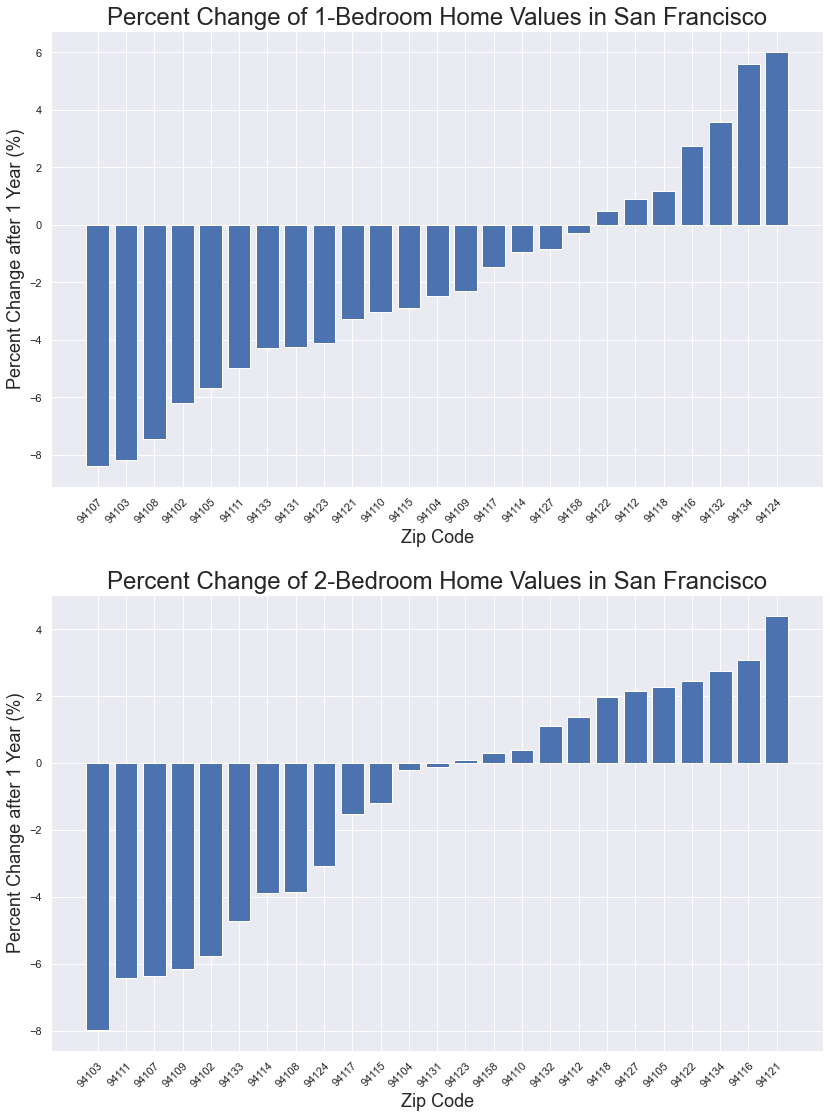

In [55]:
visualize_results(sf_1_sorted_df, sf_2_sorted_df)

# Other Params

Putting all modeling steps together, we can run a different grid search if desired.  
Note that due to the complexity of running SARIMAX on 25x2 zip codes, computational time can quickly exceed an hour.

In [ ]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict, 84)
sf_1_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict, 84)
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict, 12, 0, 3, 0, 3, 0, 2, 0, 3, 0, 3, 0, 2, False)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_2_train_dict, 12, 0, 3, 0, 2, 0, 2, 0, 3, 0, 3, 0, 2, False)
sf_1_pred_dict = evaluate_model(sf_1_train_dict, sf_1_test_dict, sf_1_best_df)
sf_2_pred_dict = evaluate_model(sf_2_train_dict, sf_2_test_dict, sf_2_best_df)
RMSE_1_df = calc_RMSE(sf_1_test_dict, sf_1_pred_dict, 1)
RMSE_2_df = calc_RMSE(sf_2_test_dict, sf_2_pred_dict, 2)
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df, 1)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df, 2)
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)
visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)